# <center> Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## Загрузка и подготовка данных

In [2]:
# Функция для графиков распределения по столбцам
def plots(table,legend=True):
    for column in table.columns:
        if table[column].dtypes != 'object' :
            if column != 'id':
                fig = plt.figure(figsize=(20,5))
                plt.subplot(1,2, 1)
                sns.histplot(data=table, x=column,legend=legend,kde=True)
                plt.title(f'Распределение, {column}')
                plt.ylabel('Частота')
                plt.xlabel(column)
                plt.subplot(1,2, 2)
                sns.boxplot(data=table, y=column)
                plt.title(f'Боксплот, {column}')
                plt.show()
    display(table.describe())
  
 

In [3]:
# Загружаем данные
try:
    region_1 = pd.read_csv('/datasets/geo_data_0.csv')
    region_2 = pd.read_csv('/datasets/geo_data_1.csv')
    region_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    region_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    region_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    region_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

table_list = [region_1, region_2, region_3] # Список таблиц
for i in table_list:
    display(i.head(3))
    display(i.info())
    

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

### Статистика

In [4]:
for table in table_list:
    display(table.info())
    display(table.describe())
    print(f'Число явных дубликатов = {table.duplicated().sum()}')
    print();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Число явных дубликатов = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Число явных дубликатов = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Число явных дубликатов = 0



In [5]:
# проверим на дубликаты  столбец с id
for table in table_list:
    display(table.duplicated(['id']).sum())
    table = table.drop_duplicates(subset=['id'])
    table.info()

10

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99996 non-null  object 
 1   f0       99996 non-null  float64
 2   f1       99996 non-null  float64
 3   f2       99996 non-null  float64
 4   product  99996 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


Region


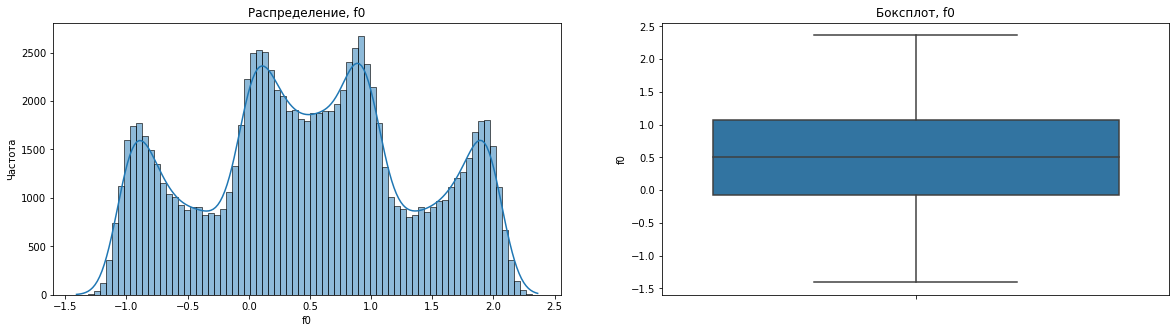

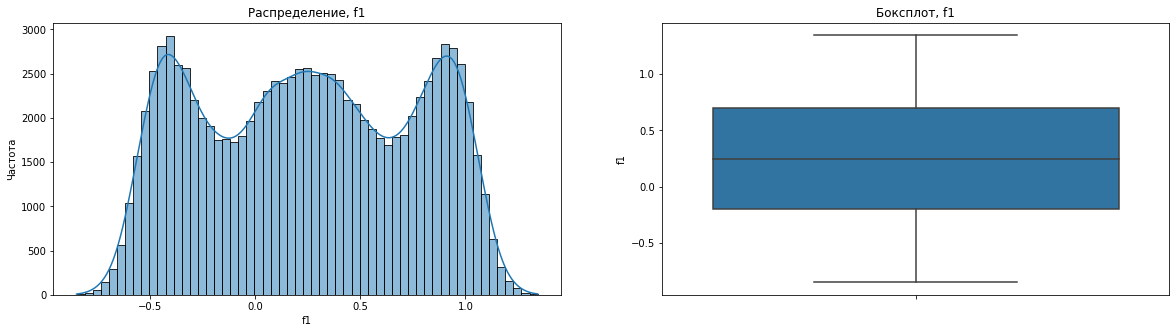

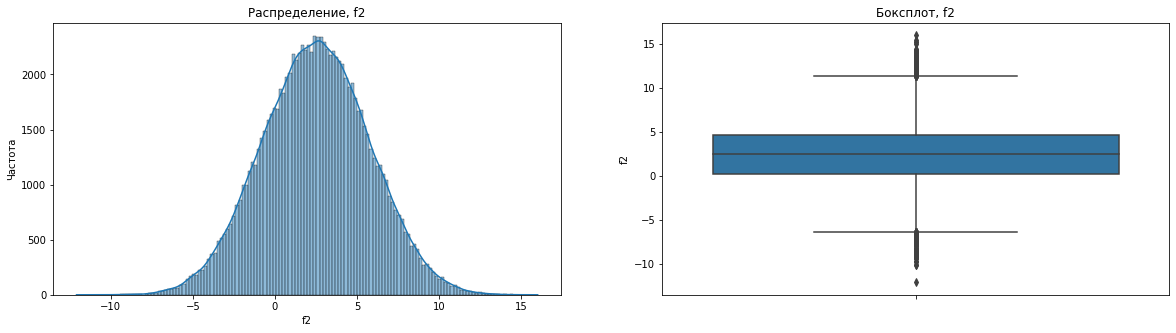

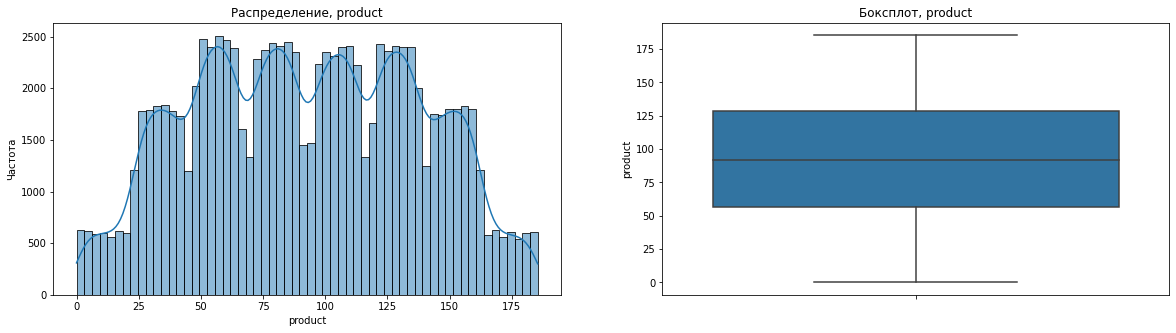

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Region


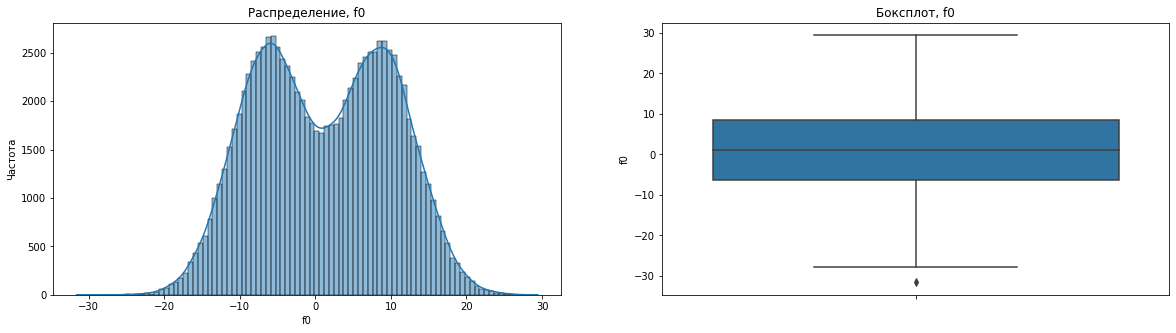

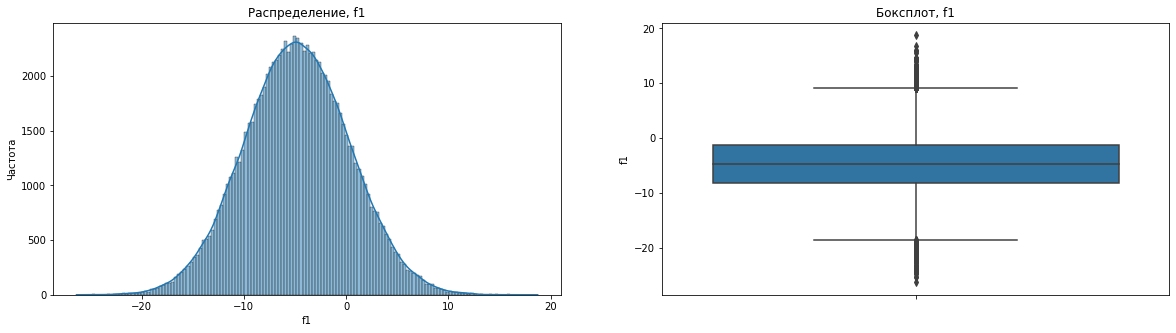

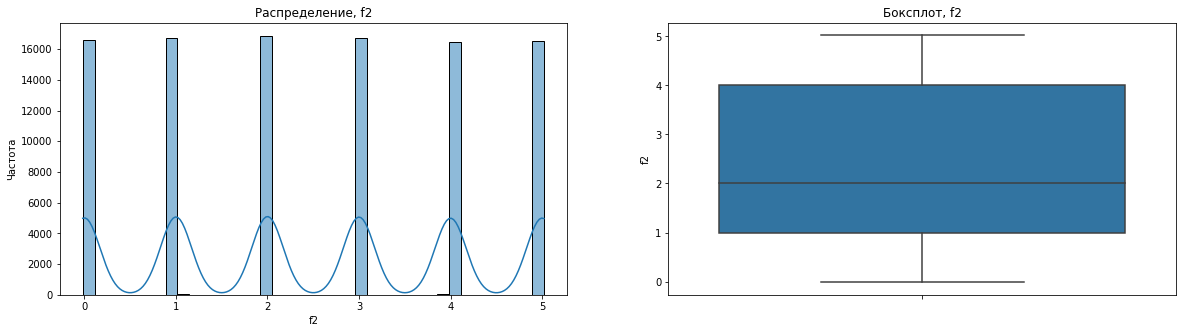

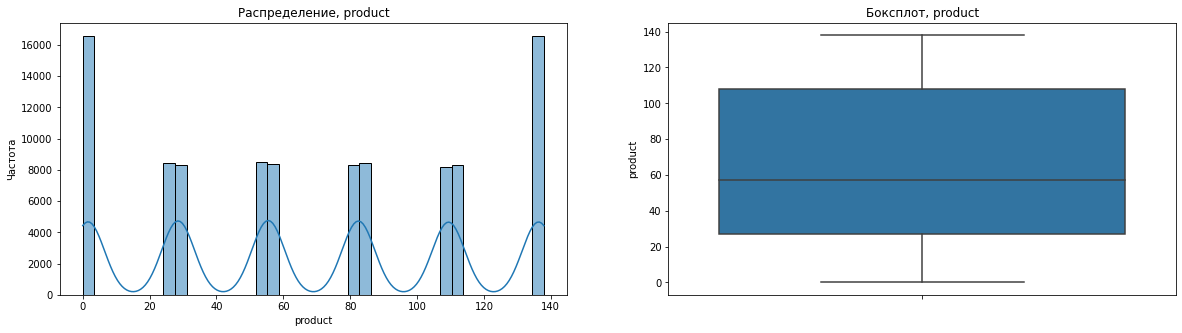

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Region


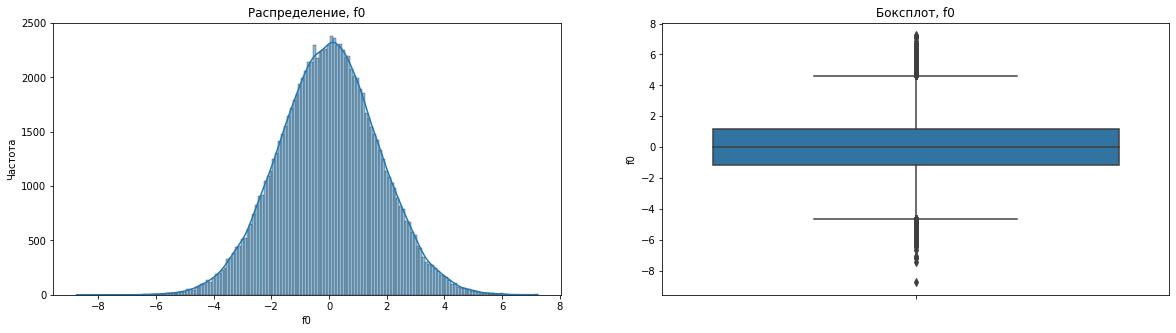

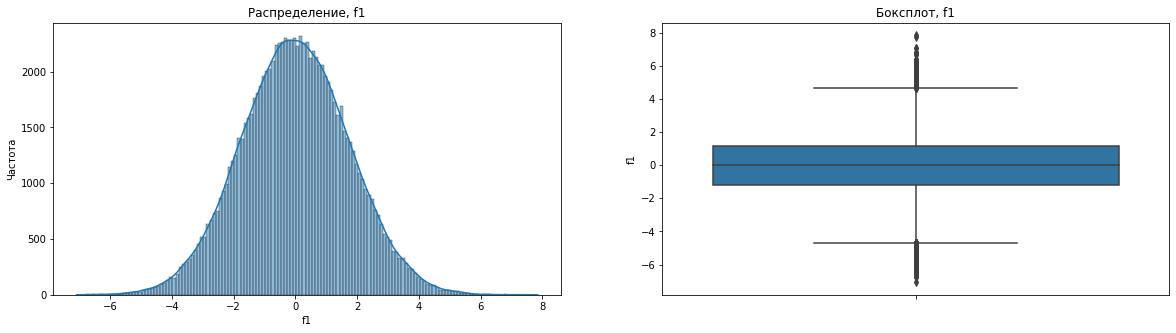

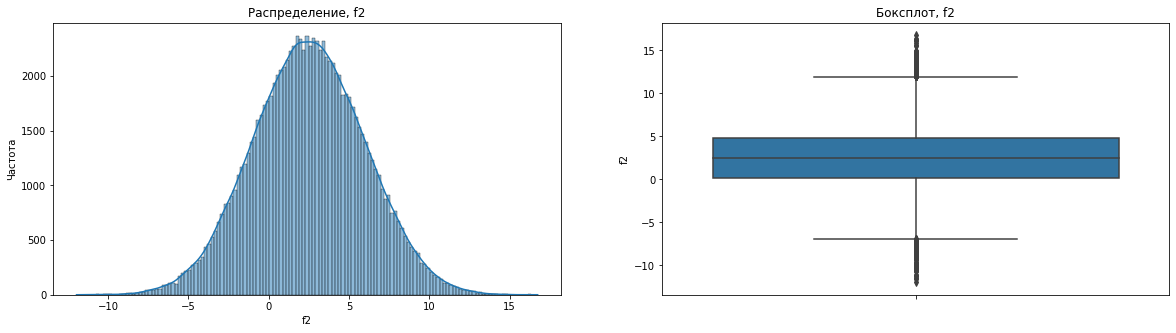

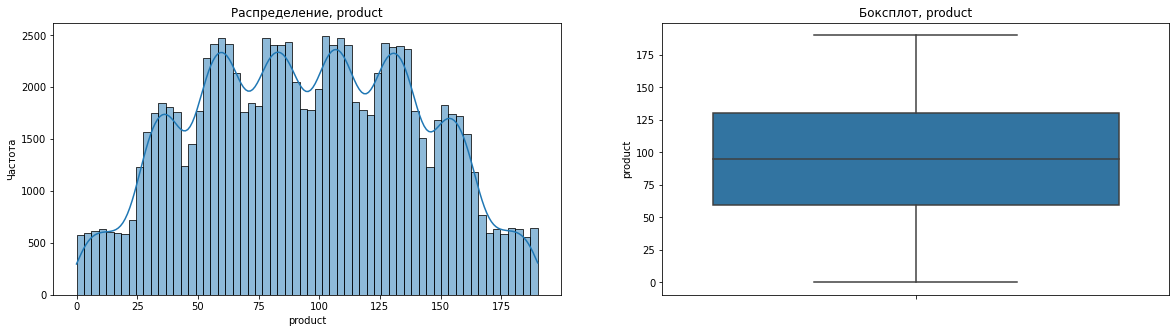

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [6]:
for table in table_list:
    print('Region')
    plots(table,legend=True);

### Вывод
- выполнили предобработку данных: 
    - удалил дубликаты в столбце с ID
    - Пропусков в данных не обнаружено
    - построил графики распределения признаков , аномалий не обнаружил
    
- подготовили данные к дальнешему анализу

## Обучение и проверка модели

### Регион №1

In [7]:
# Необходимо разбить данные на тестовую и обучающую в соотношении 75 на 25
# Регион №1
train_1, valid_1 = train_test_split(region_1, test_size=0.25, random_state=12345)
features_train_1 = train_1.drop(['product', 'id'], axis=1)
target_train_1 = train_1['product']

features_valid_1 = valid_1.drop(['product', 'id'], axis=1)
target_valid_1 = valid_1['product'] 

print(features_train_1.shape)
print(features_valid_1.shape)

(75000, 3)
(25000, 3)


In [8]:
model = LinearRegression()
model.fit(features_train_1, target_train_1)
predicted_valid_1 = model.predict(features_valid_1)
mse = mean_squared_error(target_valid_1, predicted_valid_1)


print("RMSE =", mse ** 0.5)
print("Mean =", predicted_valid_1.mean())

RMSE = 37.5794217150813
Mean = 92.59256778438035


### Регион №2

In [9]:
# Необходимо разбить данные на тестовую и обучающую в соотношении 75 на 25
# Регион №2
train_2, valid_2 = train_test_split(region_2, test_size=0.25, random_state=12345)
features_train_2 = train_2.drop(['product', 'id'], axis=1)
target_train_2 = train_2['product']

features_valid_2 = valid_2.drop(['product', 'id'], axis=1)
target_valid_2 = valid_2['product'] 

print(features_train_2.shape)
print(features_valid_2.shape)

(75000, 3)
(25000, 3)


In [10]:
model = LinearRegression()
model.fit(features_train_2, target_train_2)
predicted_valid_2 = model.predict(features_valid_2)
mse = mean_squared_error(target_valid_2, predicted_valid_2)

print("RMSE =", mse ** 0.5)
print("Mean =", predicted_valid_2.mean())

RMSE = 0.893099286775617
Mean = 68.728546895446


### Регион №3

In [11]:
# Необходимо разбить данные на тестовую и обучающую в соотношении 75 на 25
# Регион №3
train_3, valid_3 = train_test_split(region_3, test_size=0.25, random_state=12345)
features_train_3 = train_3.drop(['product', 'id'], axis=1)
target_train_3 = train_3['product']

features_valid_3 = valid_3.drop(['product', 'id'], axis=1)
target_valid_3 = valid_3['product'] 

print(features_train_2.shape)
print(features_valid_2.shape)

(75000, 3)
(25000, 3)


In [12]:
model = LinearRegression()
model.fit(features_train_3, target_train_3)
predicted_valid_3 = model.predict(features_valid_3)
mse = mean_squared_error(target_valid_3, predicted_valid_3)

print("RMSE =", mse ** 0.5)
print("Mean =", predicted_valid_3.mean())

RMSE = 40.02970873393434
Mean = 94.96504596800489


- Обучили модели для каждого региона и получили предсказания
- Наибольшее значение среднего значения объема запасов получили в 3-ем регионе
- при этом наименьшее среднее отклонение в 2-ом регионе

## Подготовка к расчёту прибыли

### Условия задачи

In [13]:
# Подготовка к расчету прибыли
# Условия задачи
BUDGET = 10000000000                  # Бюджет на разработку скважин в одном регионе
THOUSAND_BARREL_PROFIT = 450000       # Доход с 1000 барелей
MAX_RISK = 0.025                      # Максимальный риск
ONE_WELL_BUDGET = BUDGET / 200        # Стоимость разработки одной скважины

In [14]:
# Расчитаем объем добычи для окупаемости одной скважины, получим минимально необходимый объем
BAREL_FOR_PROFIT = ONE_WELL_BUDGET/(THOUSAND_BARREL_PROFIT)
display(BAREL_FOR_PROFIT);

111.11111111111111

In [15]:
print(f'Средний объём добычи в скважинах region_1: {predicted_valid_1.mean(), predicted_valid_1.mean()* THOUSAND_BARREL_PROFIT/1000- ONE_WELL_BUDGET}')
print(f'Средний объём добычи в скважинах region_2: {predicted_valid_2.mean(), predicted_valid_2.mean()* THOUSAND_BARREL_PROFIT/1000- ONE_WELL_BUDGET}')
print(f'Средний объём добычи в скважинах region_3: {predicted_valid_3.mean(), predicted_valid_3.mean()* THOUSAND_BARREL_PROFIT/1000- ONE_WELL_BUDGET}')

Средний объём добычи в скважинах region_1: (92.59256778438035, -49958333.34449703)
Средний объём добычи в скважинах region_2: (68.728546895446, -49969072.15389705)
Средний объём добычи в скважинах region_3: (94.96504596800489, -49957265.729314394)


Вывод:

    - для окупаемости необходимо добыть минимум 111,1тыс барель с одной скважины,
    - видим, что средние показатели по регионам ниже минимума окупаемости
    - вторая цифра это убыток 
    - самое высокое значение средней добычи в регионе №3, скорее всего в нем мы получим наибольшую прибыль

## Расчёт прибыли и рисков 

In [16]:
# Функция расчета прибыли
def profit(target,probas,quantity):
    target_sorted = probas.sort_values(ascending=False)
    target_sum = (target.loc[target_sorted.index][:quantity]).sum()
    total_profit = target_sum*THOUSAND_BARREL_PROFIT
    quantity_profit = total_profit - ONE_WELL_BUDGET * quantity
    return  quantity_profit
   

- Сортируем скважины по прибыльности
- суммируем прибыль 200 лучших скважин
- рассчитаем доход с 200 скважин
- прибыль = доход - расходы на строительство скважины


## Bootstrap

### Bootstrap region 1

In [17]:

state = np.random.RandomState(12345) 

values_1 = []
target_valid_1= target_valid_1.reset_index(drop=True)
for i in range(1000):
    target_subsample_1 = target_valid_1.sample(n=500, replace=True, random_state=state)
    valid_subsample_1 = pd.Series(predicted_valid_1)[target_subsample_1.index]
    values_1.append(profit(target_subsample_1, valid_subsample_1, 200))

values_1 = pd.Series(values_1)
lower_1 = values_1.quantile(0.025)

upper_1 = values_1.quantile(0.975)
mean_1 = values_1.mean()

risk_1 = ((values_1 < 0).mean()* 100, "%")

print("Регион_1")
print("Средняя прибыль:", mean_1)
print("95%-ый доверительный интервал:", lower_1, ':', upper_1)
print("Риск убытков:", risk_1)

Регион_1
Средняя прибыль: 425938526.91059244
95%-ый доверительный интервал: -102090094.83793654 : 947976353.3583689
Риск убытков: (6.0, '%')


### Bootstrap region 2

In [18]:
values_2 = []
target_valid_2 = target_valid_2.reset_index(drop=True)
for i in range(1000):
    target_subsample_2 = target_valid_2.sample(n=500, replace=True, random_state=state)
    valid_subsample_2 = pd.Series(predicted_valid_2)[target_subsample_2.index]
    values_2.append(profit(target_subsample_2, valid_subsample_2, 200))

values_2 = pd.Series(values_2)
mean_2 = values_2.mean()

lower_2 = values_2.quantile(0.025)
upper_2 = values_2.quantile(0.975)
mean_2 = values_2.mean()
risk_2 = ((values_2 < 0).mean()* 100, "%")

print("Регион_2")
print("Средняя прибыль:", mean_2)
print("95%-ый доверительный интервал:", lower_2, ':', upper_2)

print("Риск убытков:", risk_2)

Регион_2
Средняя прибыль: 518259493.6973249
95%-ый доверительный интервал: 128123231.43308444 : 953612982.0669085
Риск убытков: (0.3, '%')


### Bootstrap region 3

In [19]:
values_3 = []
target_valid_3 = target_valid_3.reset_index(drop=True)
for i in range(1000):
    target_subsample_3 = target_valid_3.sample(n=500, replace=True, random_state=state)
    valid_subsample_3 = pd.Series(predicted_valid_3)[target_subsample_3.index]
    values_3.append(profit(target_subsample_3, valid_subsample_3, 200))

values_3 = pd.Series(values_3)
mean_3 = values_3.mean()

lower_3 = values_3.quantile(0.025)
upper_3 = values_3.quantile(0.975)
mean_3 = values_3.mean()
risk_3 = ((values_3 < 0).mean()* 100, "%")

print("Регион_3")
print("Средняя прибыль:", mean_3)
print("95%-ый доверительный интервал:", lower_3, ':', upper_3)
print("Риск убытков:", risk_3)

Регион_3
Средняя прибыль: 420194005.3440501
95%-ый доверительный интервал: -115852609.16001143 : 989629939.8445739
Риск убытков: (6.2, '%')


## Общий вывод


- Загрузили и предобработали данные по 3 регионам:
        - Удалили дубликаты по id
        - Пропусков не обнаружили
- Обучили модель линейно регрессии для каждого региона
        - самую большую среднюю добычу по прогнозу получили в 3ем регионе , при этом большой разброс,
        - наиболее оптимальное значение разброса предсказаний получили во 2ом регионе
- написали функцию для расчета прибыли по определенному количеству скважин

Посчитали bootstrap для каждого региона, по результатам которого выявили регион для разработки с наименьшими рисками

    - Самая высокая средняя прибыль и наименьшие риски в регионе под номером 2, который мы и рекомендуем заказчику для разработки с минимальными рисками
    - также в этом регионе мы получили модель с минимальной средней ошибкой